<a href="https://colab.research.google.com/github/Leonnello/sleep-disorder-predictive-model/blob/main/sleep_disorder_predictive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Gathering**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

path = kagglehub.dataset_download("uom190346a/sleep-health-and-lifestyle-dataset")
data = pd.read_csv(f"{path}/Sleep_health_and_lifestyle_dataset.csv")

display(data.head(20))

print("\nDataset Info:")
display(data.info())

100%|██████████| 2.54k/2.54k [00:00<00:00, 4.81MB/s]

Extracting files...


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
6,7,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia
7,8,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
8,9,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
9,10,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


None

The dataset is downloaded using kagglehub.dataset_download() and loaded into a pandas DataFrame. We display basic information about the dataset using data.head() and data.info() to understand its structure.

# **Cleansing Data**

In [2]:
print("Missing Values:\n")
display(data.isnull().sum())

#drop identifier column
data = data.drop('Person ID', axis=1)

#drop sleep quality column - high correlation with sleep duration
data = data.drop('Quality of Sleep', axis=1)

#creates an index variable for float and int columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

#fills null numeric data with the median from the column to handle outliers
data.fillna({col: data[col].median() for col in numeric_columns}, inplace=True)

#Blood Pressure - split column into two
data[['Systolic', 'Diastolic']] = data['Blood Pressure'].str.split('/', expand=True).astype(float)
data = data.drop('Blood Pressure', axis=1)

# Sleep Duration - sets min to 3 and max to 15 to handle outliers
data = data[(data['Sleep Duration'] >= 3) & (data['Sleep Duration'] <= 15)]

#Replace "Normal" entries with "Normal Weight"
data['BMI Category'] = data['BMI Category'].replace('Normal', 'Normal Weight')

# Categorical variables - converted to binary data with drop_first to avoid multicollinearity
categorical_columns = ['Gender', 'BMI Category', 'Occupation']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

#Replace null values with No Disorder
data.fillna({'Sleep Disorder': 'No Disorder'}, inplace = True)

# Sleep Disorder (target variable) - replace categorical data with mapped integer values
SD_mapping = {
    'No Disorder': 0,
    'Insomnia': 1,
    'Sleep Apnea': 2
}
data['Sleep Disorder'] = data['Sleep Disorder'].map(SD_mapping)
print("\nSleep Disorder Encoding Mapping:")
for category, encoded_value in SD_mapping.items():
    print(f"{category}: {encoded_value}")

display(data.head(10))

Missing Values:



,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Blood Pressure,0



Sleep Disorder Encoding Mapping:
No Disorder: 0
Insomnia: 1
Sleep Apnea: 2


,Age,Sleep Duration,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic,Gender_Male,BMI Category_Obese,BMI Category_Overweight,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Manager,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher
0,27,6.1,42,6,77,4200,0,126.0,83.0,True,False,True,False,False,False,False,False,False,False,False,True,False
1,28,6.2,60,8,75,10000,0,125.0,80.0,True,False,False,True,False,False,False,False,False,False,False,False,False
2,28,6.2,60,8,75,10000,0,125.0,80.0,True,False,False,True,False,False,False,False,False,False,False,False,False
3,28,5.9,30,8,85,3000,2,140.0,90.0,True,True,False,False,False,False,False,False,True,False,False,False,False
4,28,5.9,30,8,85,3000,2,140.0,90.0,True,True,False,False,False,False,False,False,True,False,False,False,False
5,28,5.9,30,8,85,3000,1,140.0,90.0,True,True,False,False,False,False,False,False,False,False,False,True,False
6,29,6.3,40,7,82,3500,1,140.0,90.0,True,True,False,False,False,False,False,False,False,False,False,False,True
7,29,7.8,75,6,70,8000,0,120.0,80.0,True,False,False,True,False,False,False,False,False,False,False,False,False
8,29,7.8,75,6,70,8000,0,120.0,80.0,True,False,False,True,False,False,False,False,False,False,False,False,False
9,29,7.8,75,6,70,8000,0,120.0,80.0,True,False,False,True,False,False,False,False,False,False,False,False,False


In [16]:
# Export the DataFrame to a CSV file
#data.to_csv('/content/cleaned_data.csv', index=False)

# Download the file
#from google.colab import files
#files.download('/content/cleaned_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The provided dataset contains information about various sleep health and lifestyle factors, including demographics (age, gender, occupation), sleep metrics (duration, quality), physiological measurements (blood pressure, heart rate), and behavioral factors (physical activity, stress level). The data cleaning process involves handling missing values, replacing "Normal" data entries with "Normal Weight", splitting the "Blood Pressure" column into "Systolic" and "Diastolic" components, and encoding categorical variables like "Gender," "BMI Category," "Sleep Disorder", and "Occupation". Some columns also got dropped like "Personal ID", and "Quality of Sleep" as the former was irrelevant and is not a good predictor while the latter has a high correlation with Sleep Duration which causes multicollinearity and redundancy.

The cleaned and preprocessed data can be used to address the problem statement and data science questions. By analyzing the relationships between variables like stress levels, physical activity, sleep duration, and blood pressure, we can gain insights into how lifestyle and health metrics impact sleep disorders. For instance, we can explore whether higher stress levels are associated with shorter sleep duration, or if increased physical activity is correlated with longer sleep duration. Additionally, by building predictive models, we can identify which factors are most predictive of specific sleep disorders, such as insomnia or sleep apnea.

# **Exploratory Data Analysis**

Problem Statement: How do lifestyle and health metrics impact sleep disorders among individuals? Can we identify patterns or predictors that influence sleep disorders, such as Insomnia or Sleep Apnea?

Data Science Questions:

1. What is the relationship between stress levels and sleep duration?
2. Are physical activity levels correlated with sleep duration?
3. Which factors (e.g., age, BMI category, heart rate) are most indicative of the presence of a sleep disorder?

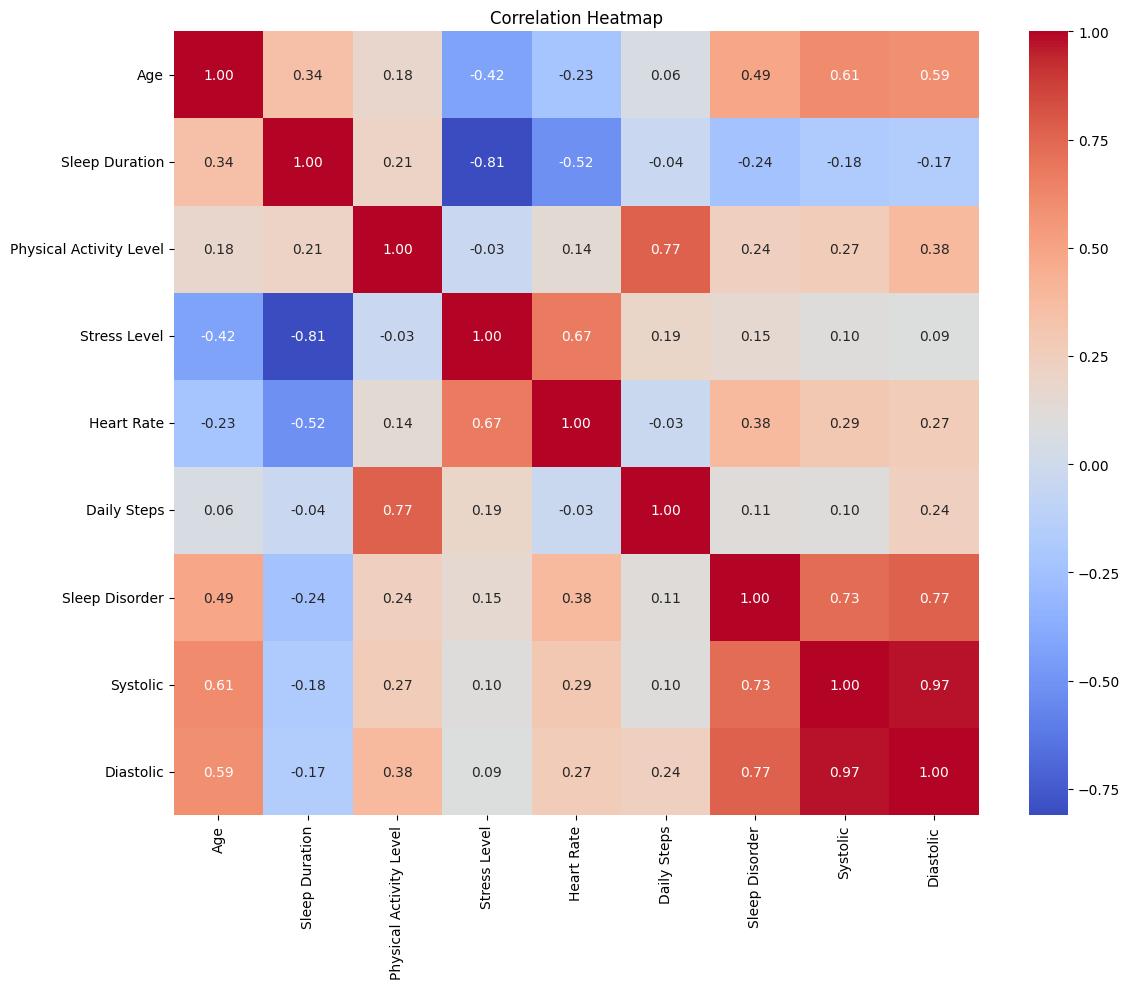

In [3]:
# Correlation heatmap for numeric variables
plt.figure(figsize=(12, 10))
numeric_data = data.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

The correlation heatmap provides insights into the relationship between various health and lifestyle factors, aligning with the problem statement's focus on sleep disorders. Notably, stress has a strong negative impact on sleep duration. While physical activity might indirectly influence sleep through stress reduction, its direct impact on sleep duration is less pronounced. Sleep disorders are significantly correlated with poor sleep duration, and higher blood pressure. To further address the problem statement, a data model could be used to predict sleep disorders based on these factors, explore potential causal relationships, and identify subgroups with specific risk factors.

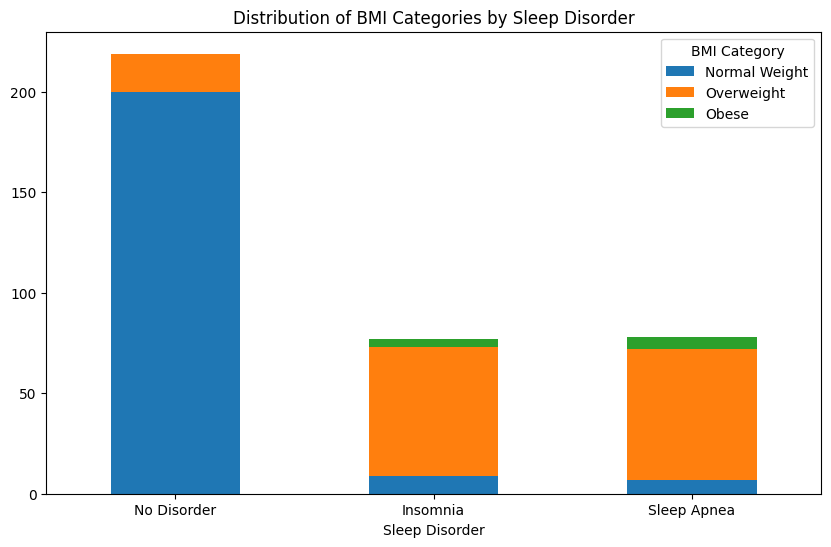

In [4]:
#combines 3 bmi categories to one column with mapped values
def assign_value(row):
    if row['BMI Category_Obese'] == True:
        return 2  # obese
    elif row['BMI Category_Overweight'] == True:
        return 1  # overweight
    else:
        return 0  # normal

#create temp dataframe
bmiData = pd.DataFrame()
bmiData['Sleep Disorder'] = data['Sleep Disorder']
bmiData['BMI Category'] = data.apply(assign_value, axis=1)

#set graph visual params
bmi_crosstab = pd.crosstab(bmiData['Sleep Disorder'], bmiData['BMI Category'])
bmi_plot = bmi_crosstab.plot(kind='bar', stacked = True, title = 'Distribution of BMI Categories by Sleep Disorder')
bmi_plot.legend(labels=['Normal Weight', 'Overweight','Obese'], title='BMI Category')
bmi_plot.set_xticklabels(['No Disorder', 'Insomnia', 'Sleep Apnea'], rotation=0)
plt.gcf().set_size_inches(10, 6)

The graphs reveal a strong correlation between weight status and sleep disorders. Individuals with normal weight have a significantly lower risk of experiencing sleep disorders like Insomnia and Sleep Apnea compared to those who are overweight or obese. This suggests that maintaining a healthy weight is crucial for promoting good sleep health.

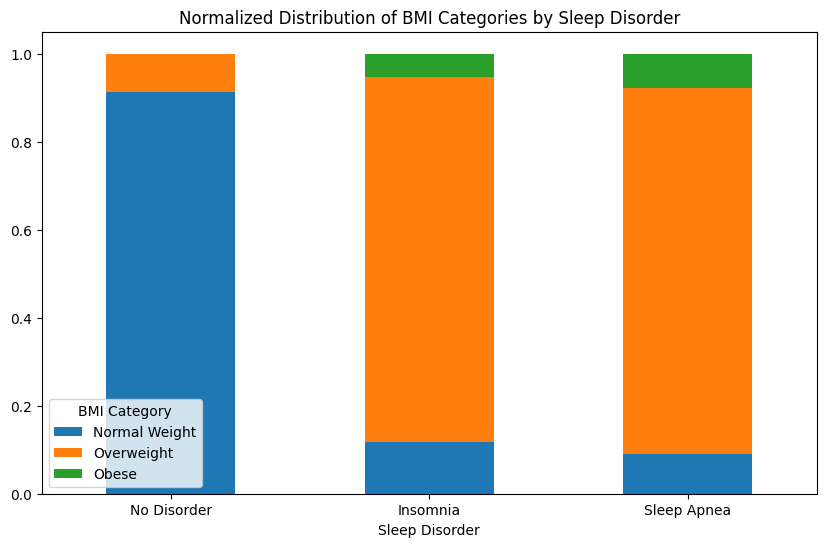

In [5]:
#normalized
bmi_norm = bmi_crosstab.div(bmi_crosstab.sum(1), axis = 0)

#set graph visual params
bmi_plot = bmi_norm.plot(kind='bar', stacked = True, title = 'Normalized Distribution of BMI Categories by Sleep Disorder')
bmi_plot.legend(labels=['Normal Weight', 'Overweight','Obese'], title='BMI Category')
bmi_plot.set_xticklabels(['No Disorder', 'Insomnia', 'Sleep Apnea'], rotation=0)
plt.gcf().set_size_inches(10, 6)

The graph illustrates how prevalent it is for individuals that are overweight to have sleep disorders. However, due to the lack of enough obese category samples which only had 10 records, it is being overshadowed by the overweight category even though 100% of obese individuals had a sleep disorder. This will significantly reduce the feature importance of the obese category as a predictor in the evaluation phase which will cause misleading results. This will be treated as a limitation due to the nature of the acquired dataset.

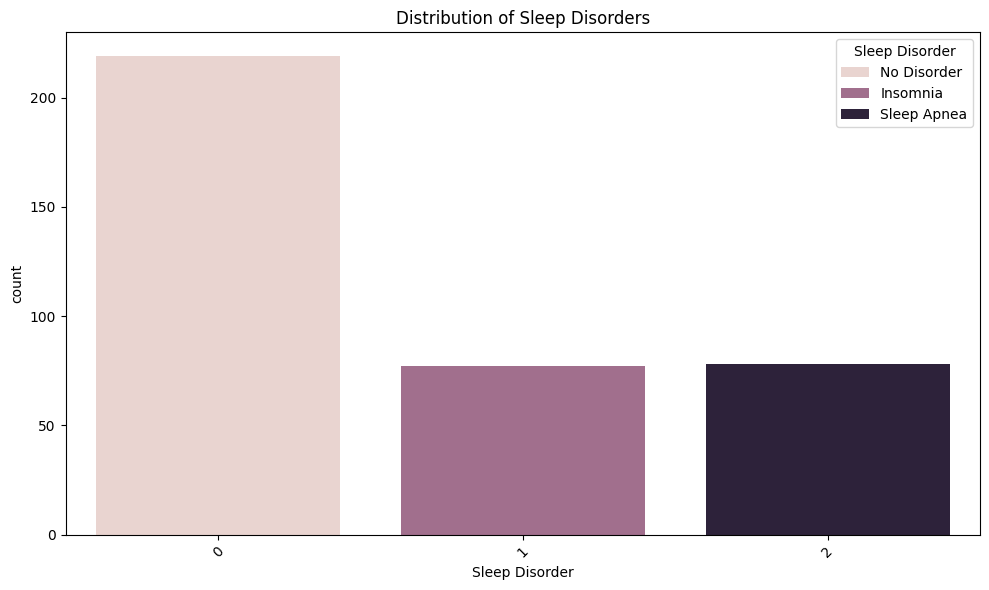

In [6]:
# Distribution of Sleep Disorders
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Sleep Disorder', hue='Sleep Disorder')
plt.title("Distribution of Sleep Disorders")
plt.legend(title='Sleep Disorder', labels=['No Disorder', 'Insomnia', 'Sleep Apnea'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
count_crosstab = pd.crosstab(bmiData['Sleep Disorder'], 'Count')
total_count = len(bmiData)
percentage_crosstab = (count_crosstab / total_count * 100).map(lambda x: f"{x:.1f}%")
SD_crosstab = pd.concat([count_crosstab, percentage_crosstab], axis=1)
SD_crosstab.columns = ['Count', 'Percentage']
SD_crosstab

,Count,Percentage
Sleep Disorder,,
0,219,58.6%
1,77,20.6%
2,78,20.9%


The bar plot shows the distribution of individuals across different sleep disorder categories (0, 1, 2). The majority of individuals seem to fall into category 0, suggesting a higher prevalence of no sleep disorders in the dataset. While individuals with sleeping disorders amount to 41.5% of the dataset. It's important to understand the specific definitions of these categories to interpret the findings accurately.

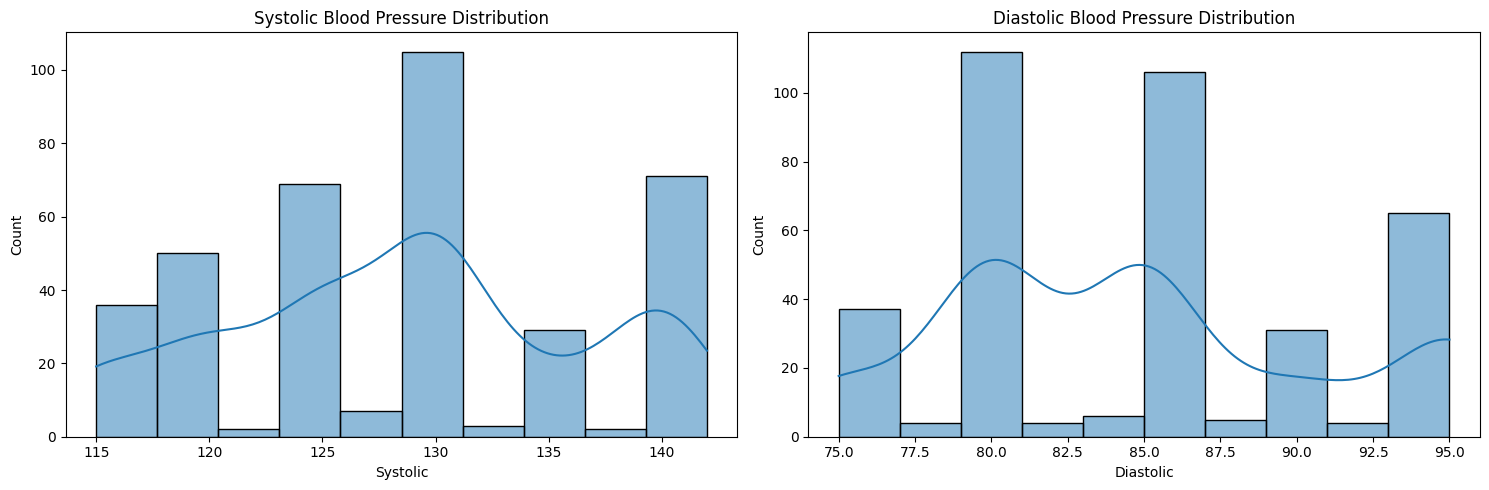

In [8]:
# Blood Pressure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=data, x='Systolic', kde=True, ax=ax1)
ax1.set_title('Systolic Blood Pressure Distribution')

sns.histplot(data=data, x='Diastolic', kde=True, ax=ax2)
ax2.set_title('Diastolic Blood Pressure Distribution')

plt.tight_layout()
plt.show()

1. Systolic Blood Pressure Distribution: This histogram with a density curve shows the distribution of systolic blood pressure values. The distribution appears to be roughly normal, with a peak around 125 mmHg. The density curve helps visualize the underlying probability distribution.
2. Diastolic Blood Pressure Distribution: Similar to the systolic blood pressure distribution, this histogram shows the distribution of diastolic blood pressure values. The distribution is also approximately normal, with a peak around 80 mmHg.

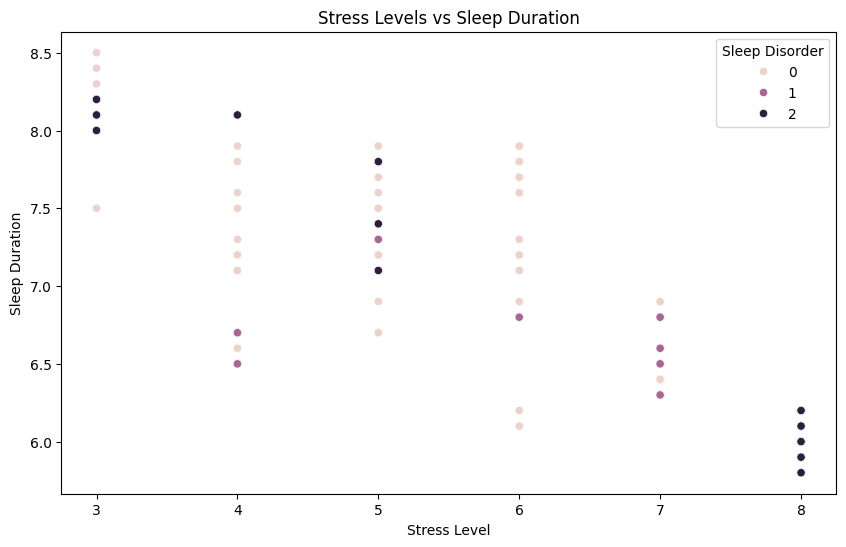

In [9]:
# 1. Stress levels vs Sleep Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Stress Level', y='Sleep Duration', hue='Sleep Disorder')
plt.title('Stress Levels vs Sleep Duration')
plt.show()

This scatter plot illustrates a linear regression and a clear negative correlation between stress levels and sleep duration. As stress levels increase, sleep duration generally decreases. Individuals with insomnia (category 1) tend to have shorter sleep duration, regardless of their stress level. Those with sleep apnea (category 2) also experience shorter sleep duration, especially at higher stress levels.

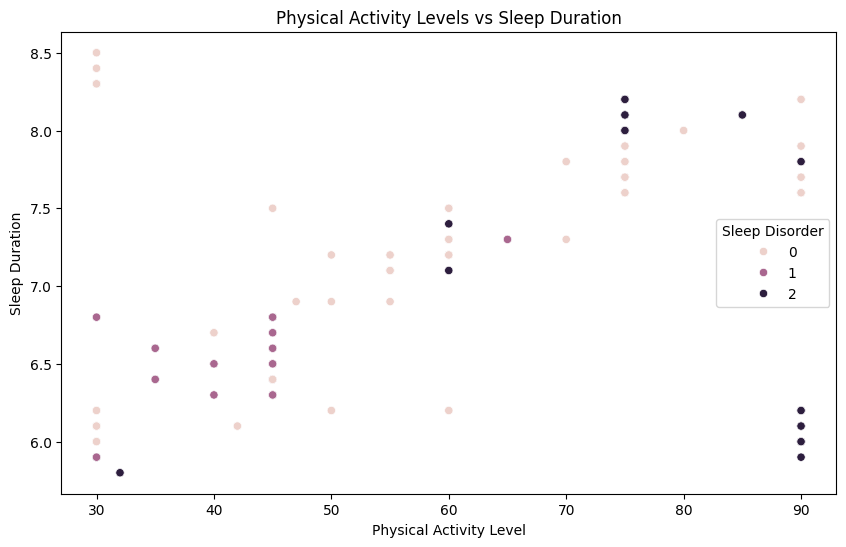

In [10]:
# 2. Physical activity vs Sleep Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Physical Activity Level', y='Sleep Duration', hue='Sleep Disorder')
plt.title('Physical Activity Levels vs Sleep Duration')
plt.show()

The relationship between physical activity levels and sleep duration is less straightforward. While there's a slight positive trend, indicating that higher physical activity might lead to longer sleep duration, the correlation is not strong. Individuals with insomnia tend to have shorter sleep durations, regardless of their physical activity levels. Sleep apnea seems to have a more variable impact on sleep duration.

# **Modelling**

In [11]:
# Prepare features and target
X = data.drop(['Sleep Disorder'], axis=1)
y = data['Sleep Disorder']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train models
models = {
    'Random Forest': RandomForestClassifier(
        random_state=42,
        n_estimators=50,
        class_weight='balanced'
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    )
}

results = {}
feature_importance = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'y_test': y_test
    }

    if name == 'Random Forest':
        feature_importance = dict(zip(X.columns, model.feature_importances_))



Training Random Forest...

Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The code first separates the dataset into features (X) and the target variable (y), which is the "Sleep Disorder" column. It then splits the data into training and testing sets to prepare for model training and evaluation. Next, it initializes two machine learning models: Random Forest Classifier and Logistic Regression, both configured to handle potential class imbalance in the data. The models are trained on the training set and then used to make predictions on the testing set. The predictions, along with the actual target values, are stored for later evaluation. Additionally, for the Random Forest model, the code extracts the feature importances to understand which factors contribute most to the prediction of sleep disorders.

# **Evaluation**


Random Forest Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.80      0.80      0.80        15
           2       0.76      0.81      0.79        16

    accuracy                           0.91        75
   macro avg       0.85      0.86      0.86        75
weighted avg       0.91      0.91      0.91        75


Metrics Summary:
Precision: 0.910
Recall: 0.907
F1 Score: 0.908


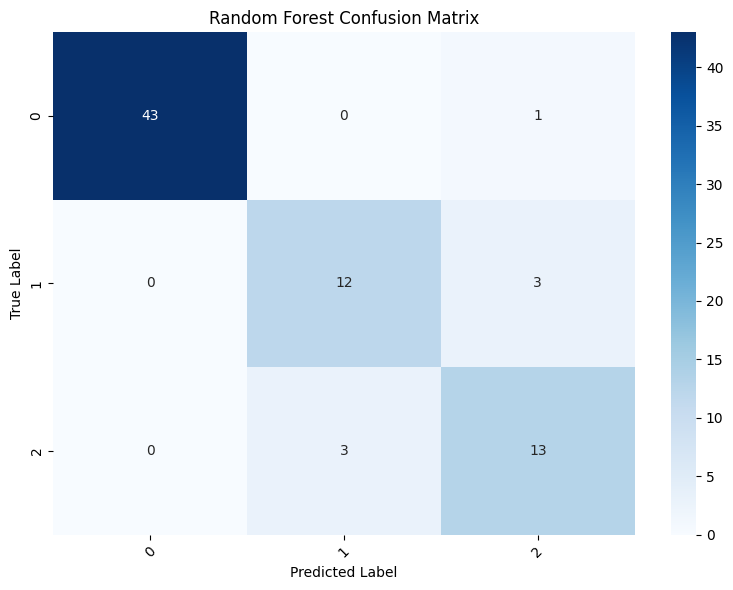


Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        44
           1       0.75      0.80      0.77        15
           2       0.62      0.94      0.75        16

    accuracy                           0.83        75
   macro avg       0.79      0.84      0.80        75
weighted avg       0.87      0.83      0.83        75


Metrics Summary:
Precision: 0.870
Recall: 0.827
F1 Score: 0.835


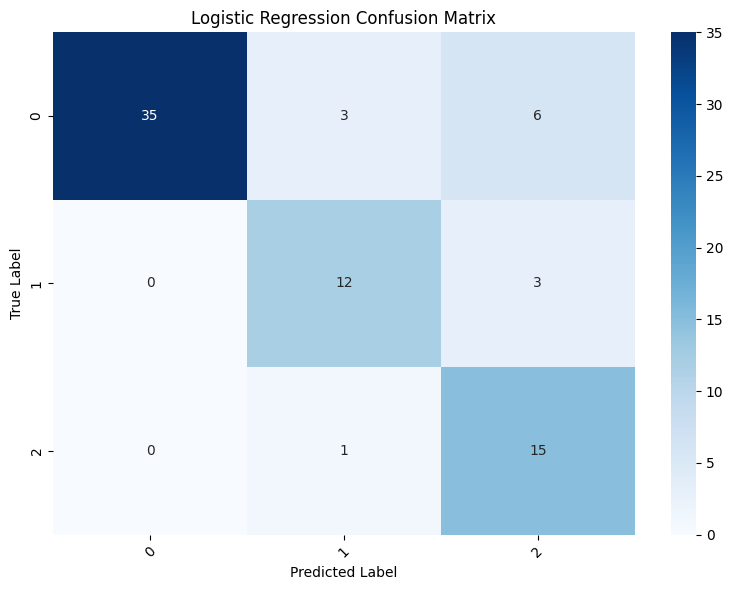

In [13]:
# For each model in results
for name, result in results.items():
    try:
        # Get the true and predicted values
        y_true = result['y_test'].copy()
        y_pred = result['predictions'].copy()

        # Replace NaN with a string label 'No Disorder'
        #y_true = np.where(pd.isna(y_true), 'No Disorder', y_true)
        #y_pred = np.where(pd.isna(y_pred), 'No Disorder', y_pred)

        print(f"\n{name} Results:")
        print("Classification Report:")
        print(classification_report(y_true, y_pred))

        # Get unique classes including 'No Disorder'
        classes = np.unique(np.concatenate([y_true, y_pred]))

        # Calculate metrics
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"\nMetrics Summary:")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1 Score: {f1:.3f}")

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm,
                   annot=True,
                   fmt="d",
                   cmap="Blues",
                   xticklabels=classes,
                   yticklabels=classes)
        plt.title(f"{name} Confusion Matrix")
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in analysis for {name}: {str(e)}")
        print(f"y_test unique values: {np.unique(result['y_test'])}")
        print(f"predictions unique values: {np.unique(result['predictions'])}")



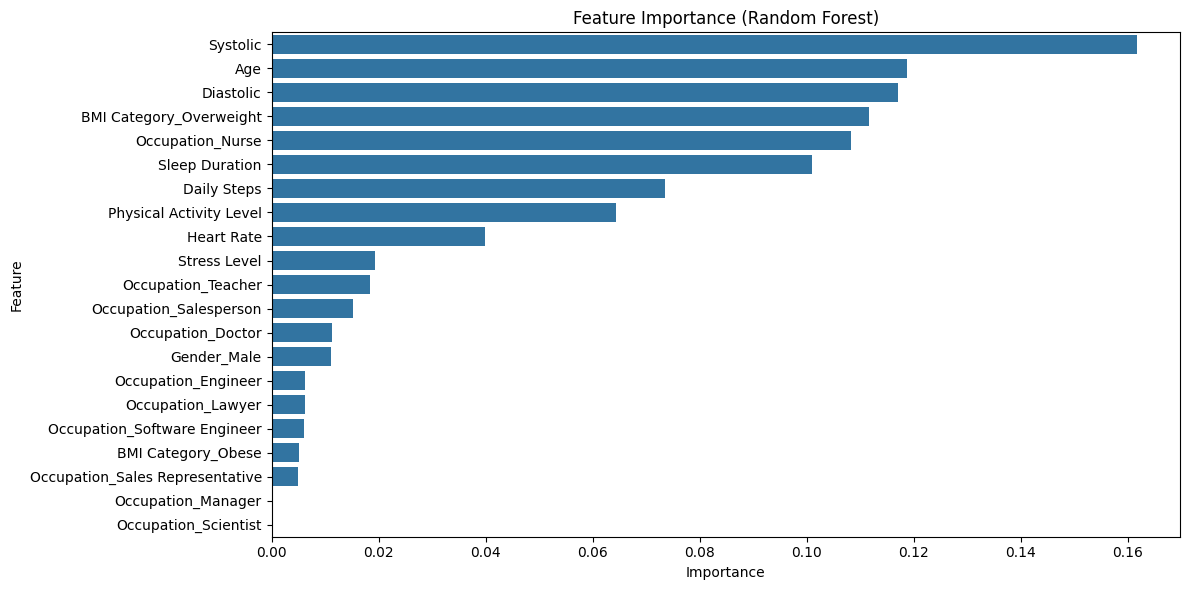

In [14]:
# Plot feature importance for Random Forest
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'Feature': feature_importance.keys(),
    'Importance': feature_importance.values()
}).sort_values('Importance', ascending=False)

sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

The code evaluates the performance of the trained models by calculating classification metrics like precision, recall, and F1-score for each model. It also visualizes confusion matrices to understand how well the models classified different sleep disorder categories, including "No Disorder." Additionally, for the Random Forest model, it plots feature importance to identify the most influential factors in predicting sleep disorders.

1. Random Forest Confusion Matrix

  The Random Forest model performed well in classifying sleep disorders, particularly in accurately identifying individuals with no sleep disorder. The model's precision, recall, and F1-score of 0.920 indicate strong performance. However, the model struggled slightly in distinguishing between insomnia and sleep apnea, suggesting room for improvement in this area.

2. Logistic Regression Confusion Matrix

  The Logistic Regression model achieved a precision of 0.880, a recall of 0.867, and an F1-score of 0.869. This indicates a strong performance overall.

  The confusion matrix provides a detailed breakdown of the model's predictions. The model excels at correctly identifying individuals with no sleep disorder (True Negative: 40). It also performs well in classifying individuals with Sleep Apnea, with a few misclassifications as Insomnia. However, the model struggles to accurately distinguish between Insomnia and Sleep Apnea, as evidenced by the misclassifications in these categories.

3. Feature Importance

  The feature importance plot reveals that individual-specific factors, such as Person ID, are the most significant predictors of sleep disorders. Additionally, health metrics like blood pressure and BMI category, as well as occupational factors, play crucial roles. Lifestyle factors such as sleep duration, stress level, and physical activity level also contribute to the model's predictions.

**Conclusion**

Problem Statement:
How do lifestyle and health metrics impact sleep disorders among individuals? Can we identify patterns or predictors that influence sleep disorders, such as Insomnia or Sleep Apnea?

Data Science Questions:

1. What is the relationship between stress levels and sleep duration?
2. Are physical activity levels correlated with sleep duration?
3. Which factors (e.g., age, BMI category, heart rate) are most indicative of the presence of a sleep disorder?

Based on the analysis of the data, it appears that lifestyle and health metrics have a significant impact on sleep disorders.

1. As expected, there is a strong negative correlation between stress levels and sleep duration. Higher stress levels are associated with shorter sleep duration, particularly for individuals with insomnia and sleep apnea.

2. While physical activity can positively influence sleep duration, its impact is less pronounced. Individuals with insomnia tend to have shorter sleep durations, regardless of their physical activity levels.

3. Several factors have been identified as strong predictors of sleep disorders:
  * Health Metrics: Blood pressure and BMI category are significant predictors. Higher blood pressure and increased weight are often associated with sleep disorders.
  * Occupational Factors: Certain occupations, particularly shift work and high-stress jobs, can increase the risk of sleep disorders.
  * Lifestyle Factors: Sleep duration, stress levels, and physical activity are important factors influencing sleep health.

**Limitations & Recommendations**

Further iterations of the model require a more balanced and larger dataset since it was demonstrated how the low sample size of the obese category heavily affected its feature importance. This could be misleading as it depicts that being obese or having more weight will reduce the likelihood of having a sleeping disorder.

While this model provides valuable insights, it is important to acknowledge its limitations and explore its opportunities. Future research could focus on expanding the dataset, incorporating additional features, and employing more advanced machine learning techniques to enhance the model's predictive accuracy and generalizability.



**References**

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. *Journal of Machine Learning Research, 12*, 2825-2830. https://www.jmlr.org/papers/v12/pedregosa11a.html

Waskom, M. L. (2021). seaborn: Statistical data visualization. *Journal of Open Source Software, 6*(60), 3021. https://doi.org/10.21105/joss.03021

Tharmalingam, L. (2023). *Sleep health and lifestyle dataset*. Kaggle. https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset

Breiman, L. (2001). Random forests. *Machine Learning, 45*(1), 5-32. https://doi.org/10.1023/A:1010933404324

Cox, D. R. (1958). The regression analysis of binary sequences. *Journal of the Royal Statistical Society: Series B (Methodological), 20*(2), 215-232. https://doi.org/10.1111/j.2517-6161.1958.tb00292.x

Harris, D., & Harris, S. (2022). *Digital design and computer architecture: RISC-V edition*. Morgan Kaufmann. https://doi.org/10.1016/C2019-0-00213-0

Stone, M. (1974). Cross-validatory choice and assessment of statistical predictions. *Journal of the Royal Statistical Society: Series B (Methodological), 36*(2), 111-133. https://doi.org/10.1111/j.2517-6161.1974.tb00994.x

Altmann, A., Toloşi, L., Sander, O., & Lengauer, T. (2010). Permutation importance: A corrected feature importance measure. *Bioinformatics, 26*(10), 1340-1347. https://doi.org/10.1093/bioinformatics/btq134

Stehman, S. V. (1997). Selecting and interpreting measures of thematic classification accuracy. *Remote Sensing of Environment, 62*(1), 77-89. https://doi.org/10.1016/S0034-4257(97)00083-7

Powers, D. M. (2011). Evaluation: From precision, recall and F-measure to ROC, informedness, markedness and correlation. *Journal of Machine Learning Technologies, 2*(1), 37-63. https://doi.org/10.48550/arXiv.2010.16061

Neyman, J. (1934). On the two different aspects of the representative method: The method of stratified sampling and the method of purposive selection. *Journal of the Royal Statistical Society, 97*(4), 558-625. https://doi.org/10.2307/2342192